# Create a GeoZarr with multi-scales containing the WebMercatorQuad TMS

## Load example dataset from NetCDF into Xarray

In [1]:
import cf_xarray  # noqa
import morecantile
import pyproj
import rioxarray  # noqa
import xarray as xr
from matplotlib import pyplot as plt
from rasterio.rio.overview import get_maximum_overview_level

# For zarr_format=2 encoding
from rio_tiler.io.xarray import XarrayReader

In [2]:
fp_base = "20020601090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1"
input = f"../data/{fp_base}.nc"
v2_output = f"../output/v2/{fp_base}_custom_multiscales.zarr"

In [3]:
ds = xr.open_dataset(input)

## Check that all variables have a CF-compliant standard name


In [4]:
standard_names = ds.cf.standard_names
vars_with_standard_names = [v[0] for v in ds.cf.standard_names.values()]
compliant_vars = []
non_complaint_vars = []
for var in ds.variables:
    if var not in vars_with_standard_names:
        non_complaint_vars.append(var)
    else:
        compliant_vars.append(var)
        assert ds[var].attrs["standard_name"]

print(f"These variables do NOT have a CF-compliant standard name: {non_complaint_vars}")
print(f"These variables have a CF-compliant standard name: {compliant_vars}")

These variables do NOT have a CF-compliant standard name: ['analysis_error', 'mask']
These variables have a CF-compliant standard name: ['time', 'lat', 'lon', 'analysed_sst', 'sea_ice_fraction']


Not all the variables in this dataset have a CF-compliant standard name. See https://github.com/zarr-developers/geozarr-spec/issues/60 for a recommendation that CF-compliant standard names should be a "SHOULD" rather than a "MUST" condition in the GeoZarr spec. For now, let's subset to the variables that do use CF-compliant standard names.

In [5]:
ds = ds[compliant_vars]

## Assign CRS information to an auxiliary variable using rioxarray

In [6]:
ds = ds.rio.write_crs("epsg:4326")
# Specify which variable contains CRS information using grid_mapping
for var in ds.data_vars:
    ds[var].attrs["grid_mapping"] = "spatial_ref"

## Define a custom TMS

crs: EPSG:4326
bounds: (-179.99500549324037, -89.99499786365084, 180.0050000000763, 89.99499786365084)


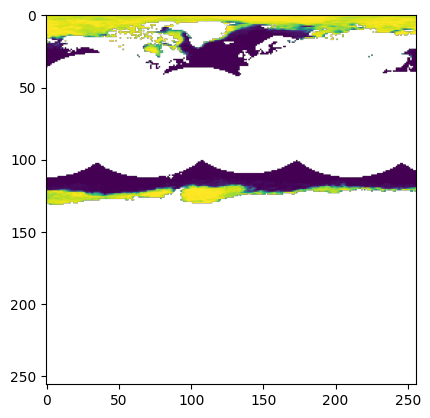

In [7]:
from morecantile.models import TileMatrix, TileMatrixSet, crs_axis_inverted, TMSBoundingBox, CRS_to_uri
from morecantile.utils import meters_per_unit
import math

x_chunk_size = 512
y_chunk_size = 512

dst_height = ds[var].shape[1]
dst_width = ds[var].shape[2]

decimation_base = 2

pyproj_crs = pyproj.CRS.from_epsg(4326)
print(f"crs: {pyproj_crs}")

bounds = tuple(ds[var].rio.bounds())
print(f"bounds: {bounds}")

is_inverted = crs_axis_inverted(pyproj_crs)

overview_level = get_maximum_overview_level(
    dst_width,
    dst_height,
    minsize=min(x_chunk_size, y_chunk_size),
)
mpu = meters_per_unit(pyproj_crs)

# Rendering pixel size. 0.28 mm was the actual pixel size of a common display from 2005 and considered as standard by OGC.
screen_pixel_size = 0.28e-3

x_origin = bounds[0] if not is_inverted else bounds[3]
y_origin = bounds[3] if not is_inverted else bounds[0]

width = abs(bounds[2] - bounds[0])
height = abs(bounds[3] - bounds[1])
res = max(width / dst_width, height / dst_height)

matrices = [
    TileMatrix(
        description="TileMatrix for the high resolution data",
        id=str(overview_level),
        scaleDenominator=res * mpu / screen_pixel_size,
        cellSize=res,
        pointOfOrigin=[x_origin, y_origin],
        tileWidth=x_chunk_size,
        tileHeight=y_chunk_size,
        matrixWidth=math.ceil(dst_width / x_chunk_size),
        matrixHeight=math.ceil(dst_height / y_chunk_size),
    )
]

for ovr in range(1, overview_level + 1):
    decimation = decimation_base ** ovr
    new_res = res * decimation
    matrices.append(
        TileMatrix(
            description=f"TileMatrix for overview {ovr}",
            id=str(overview_level - ovr),
            scaleDenominator=new_res * mpu / screen_pixel_size,
            cellSize=new_res,
            pointOfOrigin=[x_origin, y_origin],
            tileWidth=x_chunk_size,
            tileHeight=y_chunk_size,
            matrixWidth=math.ceil(dst_width / decimation / x_chunk_size),
            matrixHeight=math.ceil(dst_height / decimation / y_chunk_size),
        )
    )

matrices = reversed(matrices)

custom_tms = TileMatrixSet(
    id="custom_tms",
    title=f"Custom TMS for {var} variable",
    tileMatrices=matrices,
    orderedAxes=["Lat", "Lon"],
    crs="http://www.opengis.net/def/crs/EPSG/0/4326",
)

with XarrayReader(ds[var], tms=custom_tms) as dst:
    tile = dst.tile(0, 0, 0).data

plt.imshow(tile.squeeze())